In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import salem
import numpy as np
import geopandas as gpd
from dask.distributed import Client
import dask.dataframe as dd
import cfgrib
import datetime

In [3]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [4]:
season = '18-19'
state = 'Colorado'
statePath = 'ColoradoUtah'
region_path = '../../Data'
dataset_path = '/media/scottcha/E1/Data/RawWeatherData/gfs/' + season + '/' + statePath + '/'

In [5]:
#set number of workers i'm using 14 on my 16 thread machine
client=Client(n_workers=14, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:35323 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 14 Cores: 14 Memory: 50.55 GB


In [6]:
gfs_levels = ['unknown',
            'surface',
            'isobaricInhPa', 
            'meanSea',
            'depthBelowLandLayer',
            'heightAboveGround',
            'heightAboveGroundLayer',
            'tropopause',
            'maxWind',
            'heightAboveSea',
            'isothermZero',
            'pressureFromGroundLayer',
            'sigmaLayer',
            'sigma',
            'potentialVorticity']

In [7]:
#need to open one with parallel=False to get around a bug in cfgrib
#if using parallel=True you need to make at least 1 call with = False first to initialize cfgrib
#open all the files for a single season at surface level (multiple levels aren't supported)
#in rare events some files are corrupt, missing data or entirely missing
#for a single hourly model its liekly not a big deal as we quickly aggregate the 
#timeseries to daily values (min, avg, max) but its worth being aware of
ds = xr.open_mfdataset(dataset_path + '/gfs.0p25.2018110100.f0*.grib2.spasub.chamberlin414564', engine='cfgrib', combine='nested', concat_dim=['step'], parallel=False, backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface'}})

In [8]:
#open all the datasets
#we need to do this multiple times so that we capture all levels represnted as they are using different dims
#Note: if we get a key error here its likely that one of the input files is incomplete or corrupt
#sort by size and delete the obviously small files
tmp_ds = []

for i in range(len(gfs_levels)):
    l = gfs_levels[i]
    print('Opening Level ' + gfs_levels[i])    
    #currently we only open the first 24 hours of forecasts though dataset extends to 84 hours
    #as we expand the lenght of the prediction window we'll need to open more and process more data
    #and figure out how to handle the overlapping dims on the date
    tmp_ds.append(xr.open_mfdataset(dataset_path + '/gfs.0p25.201*00.f0[0-2]*.grib2.spasub.chamberlin414564', engine='cfgrib', combine='nested', concat_dim='time', parallel=True, backend_kwargs={'filter_by_keys': {'typeOfLevel': l}}))
    tmp_ds[i] = tmp_ds[i].where(tmp_ds[i].step < np.timedelta64(1, 'D'), drop=True)
    tmp_ds[i].attrs['Level'] = gfs_levels[i]

Opening Level unknown
Opening Level surface
Opening Level isobaricInhPa
Opening Level meanSea
Opening Level depthBelowLandLayer
Opening Level heightAboveGround
Opening Level heightAboveGroundLayer
Opening Level tropopause
Opening Level maxWind
Opening Level heightAboveSea
Opening Level isothermZero
Opening Level pressureFromGroundLayer
Opening Level sigmaLayer
Opening Level sigma
Opening Level potentialVorticity


In [9]:
def get_variables(ds):
    #find all variables in the data set and their descriptions
    variables = []
    i = 0
    for var in list(ds.data_vars.keys()):
        variables.append((i, var,ds[var].attrs['GRIB_name']))
        i += 1

    return variables

In [10]:
#Read in all avy region shapes and metadata
regions_df = gpd.read_file(region_path + '/USAvalancheRegions.geojson')
#filter to just the ones where we have lables for training
training_regions_df = regions_df[regions_df['is_training']==True].copy()
training_regions_df

,name,center,center_link,timezone,center_id,state,is_training,color,link,geometry
18,Aspen Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.91164 39.58375, -106.94518 39.5..."
19,Front Range Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-105.46760 39.03134, -105.32958 39.0..."
20,Grand Mesa Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-108.19110 39.28692, -108.26556 39.1..."
21,Gunnison Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.91731 38.99704, -106.94591 39.0..."
22,North San Juan Mountains,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.29307 37.66569, -106.26690 37.7..."
23,Sangre de Cristo Range,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-105.67377 38.30698, -105.73780 38.3..."
24,Sawatch Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.13722 39.36625, -106.14642 39.3..."
25,South San Juan Mountains,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.29307 37.66569, -106.35130 37.6..."
26,Steamboat Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.90587 39.95837, -106.91619 40.0..."
27,Vail Summit Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.14495 39.96442, -106.17302 39.9..."


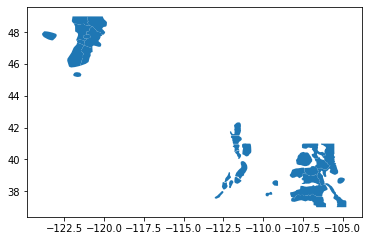

In [11]:
training_regions_df.geometry.plot()

In [12]:
#lon needs to be 0-360
training_regions_df.loc[:,'geometry'] = training_regions_df.translate(360,0)

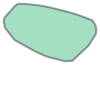

In [13]:
training_regions_df['geometry'][49]

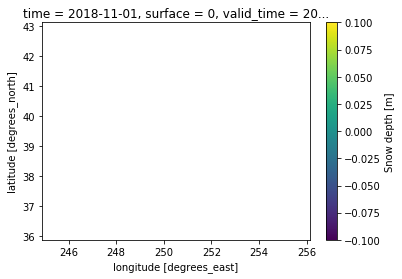

In [14]:
#will plot olympics region in wasington so ensure your data includes washington
ds.salem.roi(geometry=training_regions_df['geometry'][49]).sde[0].plot()

In [15]:
training_regions_df['center'].unique()

array(['Colorado Avalanche Information Center',
       'Northwest Avalanche Center', 'Utah Avalanche Center'],
      dtype=object)

In [16]:
#filter to just NWAC for Washington/Norther Oregon

if state == 'Washington':
    training_regions_df = training_regions_df[training_regions_df['center']=='Northwest Avalanche Center']
elif state == 'Utah':
    training_regions_df = training_regions_df[training_regions_df['center']=='Utah Avalanche Center']
elif state == 'Colorado':
    training_regions_df = training_regions_df[training_regions_df['center']=='Colorado Avalanche Information Center']

In [17]:
training_regions_df.reset_index(drop=True, inplace=True)

In [18]:
tmp_ds[0]

<xarray.Dataset>
Dimensions:     (latitude: 29, longitude: 45, time: 1264)
Coordinates:
    level       int64 0
  * latitude    (latitude) float64 36.0 36.25 36.5 36.75 ... 42.5 42.75 43.0
  * longitude   (longitude) float64 245.0 245.2 245.5 ... 255.5 255.8 256.0
  * time        (time) datetime64[ns] 2018-11-01 2018-11-01 ... 2019-04-30
    valid_time  (time) datetime64[ns] 2018-11-01T03:00:00 ... 2019-04-30T12:00:00
    step        (time) timedelta64[ns] 03:00:00 06:00:00 ... 09:00:00 12:00:00
Data variables:
    u           (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    v           (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    VRATE       (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    pwat        (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    cwat        (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    r           (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    tozne       (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    pres        (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    tcc         (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
    gh          (time, latitude, longitude) float32 dask.array<chunksize=(1, 29, 45), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-04-10T07:17:53 GRIB to CDM+CF via cfgrib-0....
    Level:                   unknown

In [19]:
#filters the dataset based on the shape defined in the regions dataset (geometry column)
#then maniupulates the dimensions to get the dataset close to a multivariate timeseries ml format 
#though we want to stay in xarray as long as possible so keepign the lat/lon dimensions seperate for now
def filter(regions, ds, level_name):
    result = {}
    
    for _, row in regions.iterrows():
        print("Calculating region: " + row['name'])
        tmp_df = ds.salem.subset(geometry=row['geometry']).salem.roi(geometry=row['geometry'])
        tmp_df = tmp_df.chunk({'time': -1}).interpolate_na(dim='time')
        print("Formatting for ML")
       
        tmp_df = tmp_df.to_array()
        #print(tmp_df)
        if level_name == 'unknown':
            level_name = 'level'
            
        if tmp_df[level_name].values.size == 1:
            tmp_df = tmp_df.drop(level_name)
            tmp_df = tmp_df.rename({'variable':'var'})
        else:
            tmp_df = tmp_df.stack(var=(level_name, 'variable'))
           
        tmp_df.transpose('latitude', 'longitude', 'var', 'time')
       
        result[row['name']] = tmp_df
    return result

In [20]:
#main method to take the raw gfs forcast data and convert it to a time series
def calculate_values(regions, data, interpolate=True):
    results = []
    for d in data:
        level = d.attrs['Level']
        #variables we'll maintain when moving from hourly to daily dataset
        min_name_dict = {}
        max_name_dict = {}
        avg_name_dict = {}
        print("Calcualting Variables")
        for k in d.data_vars.keys():
            min_name_dict[k] = 'level_' + level + '_min_' + k
            max_name_dict[k] = 'level_' + level + '_max_' + k
            avg_name_dict[k] = 'level_' + level + '_avg_' + k
            
        print("Reampling")
        resampled_ds = d.resample(time='1d')
        min_1day = resampled_ds.min().rename(min_name_dict)
        max_1day= resampled_ds.max().rename(max_name_dict)
        avg_1day = resampled_ds.mean().rename(avg_name_dict)
        
        print("Merging")
        merged_ds = xr.merge([min_1day, max_1day, avg_1day])
        
        if interpolate:
            print("Interpolating")
            #interpolate the data to try and make it more applicable to the correct spaces within regions 
            #and less applicable on the boarders of the region
            new_lon = np.linspace(merged_ds.longitude[0], merged_ds.longitude[-1], merged_ds.dims['longitude'] * 4)
            new_lat = np.linspace(merged_ds.latitude[0], merged_ds.latitude[-1], merged_ds.dims['latitude'] * 4)
            interpolated_ds = merged_ds.interp(latitude=new_lat, longitude=new_lon)
        else:
            interpolated_ds = merged_ds
        
        print("Region Filtering")
        results.append(filter(regions, interpolated_ds, level))
    return results

In [21]:
result = calculate_values(training_regions_df, tmp_ds)

Calcualting Variables
Reampling
Merging
Interpolating
Region Filtering
Calculating region: Aspen Zone
Formatting for ML
Calculating region: Front Range Zone
Formatting for ML
Calculating region: Grand Mesa Zone
Formatting for ML
Calculating region: Gunnison Zone
Formatting for ML
Calculating region: North San Juan Mountains
Formatting for ML
Calculating region: Sangre de Cristo Range
Formatting for ML
Calculating region: Sawatch Zone
Formatting for ML
Calculating region: South San Juan Mountains
Formatting for ML
Calculating region: Steamboat Zone
Formatting for ML
Calculating region: Vail Summit Zone
Formatting for ML
Calcualting Variables
Reampling
Merging
Interpolating
Region Filtering
Calculating region: Aspen Zone
Formatting for ML
Calculating region: Front Range Zone
Formatting for ML
Calculating region: Grand Mesa Zone
Formatting for ML
Calculating region: Gunnison Zone
Formatting for ML
Calculating region: North San Juan Mountains
Formatting for ML
Calculating region: Sangre de

Formatting for ML
Calculating region: Front Range Zone
Formatting for ML
Calculating region: Grand Mesa Zone
Formatting for ML
Calculating region: Gunnison Zone
Formatting for ML
Calculating region: North San Juan Mountains
Formatting for ML
Calculating region: Sangre de Cristo Range
Formatting for ML
Calculating region: Sawatch Zone
Formatting for ML
Calculating region: South San Juan Mountains
Formatting for ML
Calculating region: Steamboat Zone
Formatting for ML
Calculating region: Vail Summit Zone
Formatting for ML
Calcualting Variables
Reampling
Merging
Interpolating
Region Filtering
Calculating region: Aspen Zone
Formatting for ML
Calculating region: Front Range Zone
Formatting for ML
Calculating region: Grand Mesa Zone
Formatting for ML
Calculating region: Gunnison Zone
Formatting for ML
Calculating region: North San Juan Mountains
Formatting for ML
Calculating region: Sangre de Cristo Range
Formatting for ML
Calculating region: Sawatch Zone
Formatting for ML
Calculating region:

In [22]:
result

[{'Aspen Zone': <xarray.DataArray 'stack-0bb800b99787a9759e6117f14cf1f50a' (var: 30, time: 181, latitude: 9, longitude: 15)>
  dask.array<stack, shape=(30, 181, 9, 15), dtype=float32, chunksize=(1, 181, 9, 15), chunktype=numpy.ndarray>
  Coordinates:
    * time       (time) datetime64[ns] 2018-11-01 2018-11-02 ... 2019-04-30
    * latitude   (latitude) float64 39.04 39.1 39.17 39.23 ... 39.41 39.47 39.53
    * longitude  (longitude) float64 252.6 252.7 252.7 252.8 ... 253.4 253.4 253.5
    * var        (var) <U23 'level_unknown_min_u' ... 'level_unknown_avg_gh'
  Attributes:
      pyproj_srs:  +units=m +proj=latlong +datum=WGS84 ,
  'Front Range Zone': <xarray.DataArray 'stack-d8e1a13cad723d8fe5a665431fef7f21' (var: 30, time: 181, latitude: 42, longitude: 25)>
  dask.array<stack, shape=(30, 181, 42, 25), dtype=float32, chunksize=(1, 181, 42, 25), chunktype=numpy.ndarray>
  Coordinates:
    * time       (time) datetime64[ns] 2018-11-01 2018-11-02 ... 2019-04-30
    * latitude   (latitud

In [23]:
#take the resulting data from filtering/interpolating and reorganize it a bit to make it
#easier to work with in subsequent steps (i.e., by region)
#also stores the aggregate list of features/variables for later use when 
#the data is all merged together 
by_region = {}
variables = []
for i in range(len(result)):
    first_region = True
    for k in result[i].keys():
        if i == 0:            
            by_region[k] = []
            
        if first_region:
            variables += result[i][k].coords['var'].values.tolist()
            first_region = False
        
        by_region[k].append(result[i][k].transpose('latitude', 'longitude', 'var', 'time'))
    

In [24]:
by_region[list(by_region.keys())[0]]

[<xarray.DataArray 'stack-0bb800b99787a9759e6117f14cf1f50a' (latitude: 9, longitude: 15, var: 30, time: 181)>
 dask.array<transpose, shape=(9, 15, 30, 181), dtype=float32, chunksize=(9, 15, 1, 181), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) datetime64[ns] 2018-11-01 2018-11-02 ... 2019-04-30
   * latitude   (latitude) float64 39.04 39.1 39.17 39.23 ... 39.41 39.47 39.53
   * longitude  (longitude) float64 252.6 252.7 252.7 252.8 ... 253.4 253.4 253.5
   * var        (var) <U23 'level_unknown_min_u' ... 'level_unknown_avg_gh'
 Attributes:
     pyproj_srs:  +units=m +proj=latlong +datum=WGS84 ,
 <xarray.DataArray 'stack-06cd822b3af9c263c1205e15bc8433db' (latitude: 9, longitude: 15, var: 63, time: 181)>
 dask.array<transpose, shape=(9, 15, 63, 181), dtype=float32, chunksize=(9, 15, 1, 181), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) datetime64[ns] 2018-11-01 2018-11-02 ... 2019-04-30
   * latitude   (latitude) float64 39.04 39.1 39.17 39.23 ... 39.41

In [25]:
len(variables)

738

In [26]:
get_variables(tmp_ds[1])

[(0, 'vis', 'Visibility'),
 (1, 'gust', 'Wind speed (gust)'),
 (2, 'hindex', 'Haines Index'),
 (3, 'sp', 'Surface pressure'),
 (4, 'orog', 'Orography'),
 (5, 't', 'Temperature'),
 (6, 'sdwe', 'Water equivalent of accumulated snow depth (deprecated)'),
 (7, 'sde', 'Snow depth'),
 (8, 'pevpr', 'Potential evaporation rate'),
 (9, 'cpofp', 'Percent frozen precipitation'),
 (10, 'wilt', 'Wilting Point'),
 (11, 'fldcp', 'Field Capacity'),
 (12, 'SUNSD', 'Sunshine Duration'),
 (13, 'lftx', 'Surface lifted index'),
 (14, 'cape', 'Convective available potential energy'),
 (15, 'cin', 'Convective inhibition'),
 (16, '4lftx', 'Best (4-layer) lifted index'),
 (17, 'hpbl', 'Planetary boundary layer height'),
 (18, 'lsm', 'Land-sea mask'),
 (19, 'siconc', 'Sea ice area fraction'),
 (20, 'landn', 'Land-sea coverage (nearest neighbor) [land=1,sea=0]')]

In [27]:
#If we need to look up an index in to numpy for a variable this is how you do it
variables.index('level_surface_avg_sde')

79

In [28]:
list(by_region.keys())[-1]

'Vail Summit Zone'

In [29]:
#this is how you do the below in xarray though something 
#is wrong and I end up with a broadcast error once it tries to 
#compute

#t = xr.concat(by_region['Abajos'], dim='var')
#date_values_pd = pd.date_range("2015-05-02", periods=365, freq="D")
#t2 = t.reindex({'time': date_values_pd})
#t2.expand_dims(dim={'season': ['15-16'], 'region': ['Abajos']})

In [ ]:

#Warning: this method takes a long time as it will force most of the 
#dask tasks we've been batching up to execute in order to move to numpy dataset
#sometimes this randomly fails with "Too Many Indicies" seems to be a bug in some 
#dependency.  Rerunning usually resolves it.
np_result = []
for k in list(by_region.keys()):
    #TODO: eventually we should do these two steps directly in xarray though they both seem to fail
    #right now so doing in np as a workaround
    print('region: ' + k)
    tmp = np.concatenate(by_region[k], axis=2)
    np_result.append(tmp)
   
speak('Done')

region: Aspen Zone


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


region: Front Range Zone


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

region: Grand Mesa Zone


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

region: Gunnison Zone


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

region: North San Juan Mountains


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.nanny - WARNING - Restarting worker
distributed.utils_perf - WARNING - full garb

region: Sangre de Cristo Range


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

region: Sawatch Zone


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [ ]:
#np_result3 = np_result + np_result2

In [ ]:
#np_result = np_result3

In [ ]:
len(by_region.keys())

In [ ]:
#pad the time value
#fill forward so that we have 0 for all values up to Nov 1 so that we can select a 180 
#range for every day we are predicting starting around Dec 1
for i in range(len(np_result)):
    r = np_result[i]
    r = np.pad(r, [(0, 0), (0, 0), (0, 0), (365-r.shape[3],0)], mode='constant', constant_values=0)
    np_result[i] = r

In [ ]:
#np_result = np_result2 + np_result[3:]

In [ ]:
#np_result = np_result + np_result2
#len(np_result+np_result2)

In [ ]:
#this needs to be adjusted so that end date always ends on april 30 (i.e., for leapyears)
#create the time dimension so we can move back to xarray
date = np.array('2018-05-01', dtype=np.datetime64) #use 5-2 for leapyears
date_values = date + np.arange(365)

In [ ]:
list(date_values[-10:])

In [ ]:
speak('done')

In [ ]:
#here"
len(np_result)

In [ ]:
#move back to xarray with our now consolodated data so that we can store it to the disk cache
#while maintaining the labeled dimensions
keys = list(by_region.keys())
xr_results = []
for i in range(len(keys)):
    xr_results.append( xr.DataArray(np_result[i][np.newaxis, np.newaxis, :], dims=('season', 'region', 'latitude', 'longitude', 'var', 'time'), 
                                       coords = {'season':[season],
                                                 'region':[keys[i]],
                                                 'latitude':by_region[keys[i]][0].latitude.values, #always using 0 as all lat lon for the datasets should be identical
                                                 'longitude':by_region[keys[i]][0].longitude.values,
                                                  'var':variables,
                                                  'time':date_values
                                                 })
                     )
    
    

In [ ]:
xr_results[0].region.values[0]

In [ ]:
#Store the values to disk
for k in xr_results:
    #TODO: seems to be a bug in xarray handling some fo the data wiht the default netcdf engine it chooses
    #as this throws an error
    #xr_results[k].to_netcdf('/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/Region_' + k + '_15-16.nc')
    
    #this works
    k.to_netcdf('/media/scottcha/Data/Temp/GFSFiltered/Region_' + k.region.values[0] + '_' + season + '.nc', engine='h5netcdf')

In [ ]:
#check that the stored data works
alldata = xr.open_dataset('/media/scottcha/Data/Temp/GFSFiltered/Region_Mt Hood_18-19.nc')#, combine='nested', concat_dim='region', chunks={'season': 1, 'region': 1, 'latitude': 10, 'longitude': 10, 'var': 735, 'time': 30})

In [ ]:
alldata

In [ ]:
#This is code to filter to all the potential world avy locations
#avy_regions_shp = salem.read_shapefile('../../GetTrainingData/CreateGlobalAvyRegions/WorldAvyRegionsShapeV2/WorldAvyRegionsV2.shp')
#avy_regions_shp.plot()
#avy_regions_shp2 = avy_regions_shp.translate(360,0)
#avy_regions_shp2[0]
#merged_filtered_ds = merged_interpolated_ds.salem.roi(geometry=avy_regions_shp2[0])
#this is the filtered snowdepths for the first day in the dataset
#merged_filtered_ds.avg_sde[100].plot()